<a href="https://colab.research.google.com/github/fashion-mnist-classification/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>

## Deep Learning


> Antonopoulos Ilias p3352004 </br>
> Ndoja Silva p3352017 </br>
> Postgraduate Students, MSc Data Science AUEB </br>

## Table of Contents

- [Data Loading](#Data-Loading)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Hyperparameter Tuning](#Hyperparameter-Tuning)
- [Model Selection](#Model-Selection)
- [Evaluation](#Evaluation)

In [1]:
import keras_tuner as kt
import matplotlib.pyplot as plt
import tensorflow as tf

2022-02-26 14:56:50.691213: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-26 14:56:50.691231: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
print(tf.__version__)

2.8.0


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  0


2022-02-26 14:56:52.329968: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-26 14:56:52.330425: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-26 14:56:52.333816: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2022-02-26 14:56:52.333859: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusparse.so.11'; dlerror: libcusparse.so.11: cannot open shared object file: No such file or directory
2022-02-26 14:56:52.333950: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Canno

**tip**: Open the Google Colab link at the top for a GPU runtime. 

### Data Loading

In [4]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [5]:
train_images.shape

(60000, 28, 28)

In [6]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [7]:
set(train_labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [8]:
test_images.shape

(10000, 28, 28)

This is a dataset of 60,000 28x28 grayscale images of 10 fashion categories,
  along with a test set of 10,000 images.
  
The classes are:
  
| Label | Description |
|:-----:|-------------|
|   0   | T-shirt/top |
|   1   | Trouser     |
|   2   | Pullover    |
|   3   | Dress       |
|   4   | Coat        |
|   5   | Sandal      |
|   6   | Shirt       |
|   7   | Sneaker     |
|   8   | Bag         |
|   9   | Ankle boot  |

In [9]:
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

### Exploratory Data Analysis

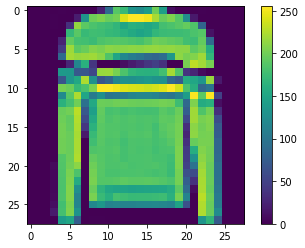

In [10]:
plt.figure()
plt.imshow(train_images[5])
plt.colorbar()
plt.grid(False)
plt.show()

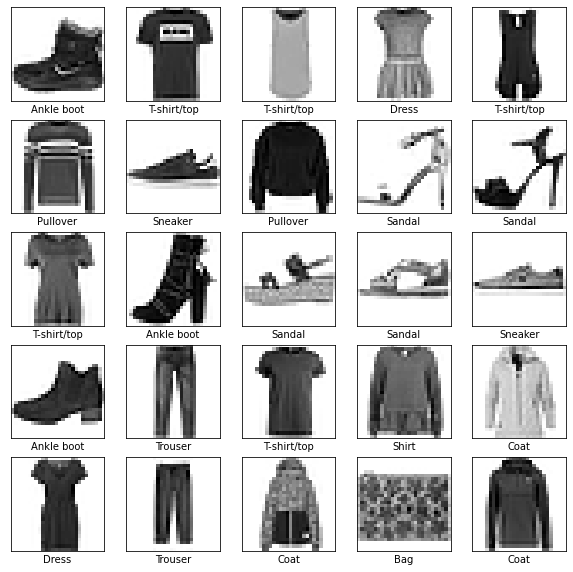

In [11]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

### Hyperparameter Tuning

In [12]:
def model_builder(hp):

    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
    model.add(tf.keras.layers.Rescaling(scale=1.0 / 255))

    hp_units = hp.Int("units", min_value=32, max_value=512, step=32)
    model.add(tf.keras.layers.Dense(units=hp_units, activation="relu"))
    model.add(tf.keras.layers.Dense(10))

    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )

    return model

In [13]:
tuner = kt.Hyperband(
    model_builder,
    objective="val_accuracy",
    max_epochs=5,
    factor=3,
    directory="hparam-tuning",
    project_name="mlp",
)

2022-02-26 14:56:53.415520: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

In [19]:
tuner.search(
    train_images, train_labels, epochs=5, validation_split=0.2, callbacks=[stop_early]
)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(
    f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
"""
)

Trial 13 Complete [00h 00m 14s]
val_accuracy: 0.8798333406448364

Best val_accuracy So Far: 0.8798333406448364
Total elapsed time: 00h 02m 51s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 352 and the optimal learning rate for the optimizer
is 0.001.



#### Model Selection

In [20]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_images, train_labels, epochs=10, validation_split=0.2)

val_acc_per_epoch = history.history["val_accuracy"]
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print("Best epoch: %d" % (best_epoch,))

Epoch 1/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4960 - accuracy: 0.8230 - val_loss: 0.3979 - val_accuracy: 0.8609
Epoch 2/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3694 - accuracy: 0.8651 - val_loss: 0.3531 - val_accuracy: 0.8751
Epoch 3/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3334 - accuracy: 0.8770 - val_loss: 0.3462 - val_accuracy: 0.8749
Epoch 4/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3063 - accuracy: 0.8862 - val_loss: 0.3408 - val_accuracy: 0.8773
Epoch 5/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2879 - accuracy: 0.8933 - val_loss: 0.3325 - val_accuracy: 0.8809
Epoch 6/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2701 - accuracy: 0.8989 - val_loss: 0.3244 - val_accuracy: 0.8842
Epoch 7/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2612 - accuracy: 0.9024 - val_loss: 0.3305 - val_accuracy:

In [21]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(train_images, train_labels, epochs=best_epoch, validation_split=0.2)

Epoch 1/9
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4977 - accuracy: 0.8239 - val_loss: 0.4019 - val_accuracy: 0.8529
Epoch 2/9
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3716 - accuracy: 0.8637 - val_loss: 0.4049 - val_accuracy: 0.8542
Epoch 3/9
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3315 - accuracy: 0.8779 - val_loss: 0.3461 - val_accuracy: 0.8747
Epoch 4/9
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3054 - accuracy: 0.8871 - val_loss: 0.3287 - val_accuracy: 0.8809
Epoch 5/9
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2858 - accuracy: 0.8934 - val_loss: 0.3144 - val_accuracy: 0.8889
Epoch 6/9
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2705 - accuracy: 0.8996 - val_loss: 0.3213 - val_accuracy: 0.8854
Epoch 7/9
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2564 - accuracy: 0.9048 - val_loss: 0.3148 - val_accuracy: 0.8893

### Evaluation

In [22]:
eval_result = hypermodel.evaluate(test_images, test_labels)
print("[test loss, test accuracy]:", eval_result)

313/313 [==============================] - 1s 2ms/step - loss: 0.3343 - accuracy: 0.8779
[test loss, test accuracy]: [0.33431878685951233, 0.8779000043869019]
